## import

In [1]:
#importing libraries & packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# import Animal Control Incidents df
df = pd.read_csv('Animal_Control_Incidents.csv')

#preserving original df before making alterations
raw_df = df.copy()

## functions

In [3]:
# regex for letters and '/' only, unless pattern reassigned
def remove_numpunc(list, pattern='[^A-Za-z,]+'):
    """regex to apply to list/df column --default: to include only letters and '/' """
    pattern = pattern
    #pattern = '[^A-Za-z_]+'
    if pattern =='[^A-Za-z,]+':
        list = [re.sub(pattern, ',', i) for i in list] 
    if pattern == '[^A-Za-z_]+':
        list = [re.sub(pattern, '', i) for i in list]
    if pattern == '[^A-Za-z/]+':
        list = [re.sub(pattern, '/', i) for i in list]
    if pattern == '[^0-9]+':
        list = [re.sub(pattern, '', i) for i in list]
    return list

In [4]:
# str type, eliminate misplaced whitespace, lower casing, replacing blankspace with '_'
def clean_str(col):
    df[col] = df[col].astype(str)
    df[col] = df[col].str.strip()
    df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
    df[col] = df[col].str.lower()

In [5]:
# plotting counts of timedate data 
def plot_dtcount(td_df, col, limitsy = None, limitsx= None, overlap = True, labels = None):
    """Plots incident count(y) with timeframe as x axis:
    
        td_df = dataframe with date/time
        col = date/time column(s) of dataframe to plot counts
        limitsy= (y,y), limitsx= (x,x) can be adjusted
         -, helful if wanting to exclude extreme outliers -
         overlap= boolean(if looping and want plots seperately plotted, set to False)
         labels= str or list of str for legend
         """
    
    td_df[col] = td_df[col].dropna()
    time_c = td_df.groupby([col])[col].count()
    
    if limitsy:
        plt.ylim(limitsy)
        
    if limitsx:
        plt.xlim(limitsx)

    if labels:
        plt.legend(
        (labels),
        loc='upper right'
        ,fontsize= 12)
    
    plt.scatter(time_c.index, time_c.values, s= 5, alpha=.3, label=col)
    if not overlap:
        plt.xlabel(col)
        plt.show();

In [6]:
# pretty blue/green seaborn correlation plot for categorical data
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    """pretty blue/green seaborn correlation plot:
    
    data= dataframe(will include all columns)
    minv = -float, maxv = float  --adjust closer to 0 for more contrast, closer to -1/1 for less
    dummy = False if df is all numerical. when True:function will only dummy categorical features
    """
    
    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

In [7]:
#sns countplot loop - probably unnecessary
def plot_counts(cols):
    for i, col in enumerate(cols):
       # print(df[col].value_counts())
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [8]:
# replacing strings and substrings FOR COLOR COLUMN ONLY(could be made more universal)
def edit_replace(old_words, replacement_word):
    """simple replacing strings or list in the df.color column since used so frequently in editting"""
    for word in old_words:
        df['color'] = df['color'].apply(lambda x: x.replace(word, replacement_word))

# __Cleaning__

### overview

looking at size, data types, 'na's

In [9]:
df.shape

(73303, 38)

In [10]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


In [11]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file_number             73303 non-null int64
incident_date           73303 non-null object
incident_time           72818 non-null object
dispatched_time         62547 non-null object
call_taker              53134 non-null object
dispatcher              60239 non-null object
dispatched_other        73303 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62545 non-null object
complainant_street      73281 non-null object
request_type            40141 non-null object
officer                 61235 non-null object
equipment_number        60251 non-null object
remarks                 2098 non-null object
impound_number          53110 non-null float64
impound_date            53105 non-null object
impound_time            53046 non-null object
location                52867 non-null object
municipality       

Although most features are classified appropriately, some of these columns would be better described as object than int or float. There are also many dates and times to convert to datetime.

In [13]:
# float and int columns with no numerical value
obj_cols = ('file_number', 'dispatched_other', 'impound_number', 'zip_code', 'color', 'breed')

# converting to object
for col in obj_cols:
    df[col] = df[col].astype(str)

In [14]:
# any duplicate rows?
print (len(df[df.duplicated()])/len(df))
# df[df.duplicated()]

0.003396859610111455


Other than the majority of them appearing around the year 2012, nothing grabs my attention with the duplicates. It only accounts for .03% of df.

In [15]:
# removing duplicate rows from df - likely data entry mistakes
df.drop_duplicates(keep=False, inplace=True)

How much nas per column are there?

In [16]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number               0.0
incident_date             0.0
incident_time             1.0
dispatched_time          14.0
call_taker               27.0
dispatcher               18.0
dispatched_other          0.0
dispatched_situation     14.0
arrival_time             15.0
available_time           14.0
complainant_street        0.0
request_type             45.0
officer                  17.0
equipment_number         18.0
remarks                  97.0
impound_number            0.0
impound_date             28.0
impound_time             28.0
location                 28.0
municipality             28.0
zip_code                  0.0
service_code             28.0
species                  28.0
breed                     0.0
sex                      45.0
size                     29.0
color                     0.0
age                      55.0
condition                31.0
temperment               30.0
collar                   66.0
collar_color             66.0
vaccination_number       99.0
vaccinatio

Since most features are missing substantial amounts of data, I want to be careful about dropping nas to avoid tossing out useful information with the nulls.

In [17]:
#removing row with nas from incident time since such little nas(1% rows)
df = df[df['incident_time'].notna()]

In [18]:
# preserve df 
df1 = df.copy()

In [19]:
#df=df1

### date & time

Converting dates and times to appropriate format.


- Merging incident date and time to datetime column, repeat with impound date & time.

In [20]:
# incident date + incident time for merged datetime column
df['inc_dt'] = pd.to_datetime(df['incident_date'].apply(str)+' '+df['incident_time'])

In [21]:
# impound date + impound time = impound datetime
df['imp_dt'] = pd.to_datetime(df['impound_date'].apply(str)+' '+df['impound_time'], errors ='coerce')

___
__Time Features:__

In [22]:
# time columns to list, then loop conversion to date.time
time_cols= [col for col in df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [23]:
print('Incident time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

Incident time Range:
from 00:04:00 
 to: 23:58:00


___
__Date Features:__

In [24]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

# covert to month/day/year datetime format
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y").dt.date

In [25]:
# date range of dataset
print('Incident Date Range:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

Incident Date Range:
from: 2012-01-01 
 to: 2019-10-03


#### additional time features:

___
Below, I will be:


- Creating feature representing time difference between incident time and impound time.  

*_The incident date&time is when the incident was called in, the impound time is when the animal was brought to the shelter. It's possible that not every incident called in resulted in an impound, which may be the reason values are missing from impound._


__difference between datetime of incident call and impound datetime__

In [26]:
# time difference from incident to impound
df['inc_to_imp'] = df['imp_dt']-df['inc_dt']

___
Weekday and Month:

This may not provide anything insightful, but I'm creating columns for weekday and month of incident.

__- Weekday Feature-__

In [27]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['incident_date']).apply(lambda x: x.weekday())

df.weekday.value_counts()
# 0= monday

0    15960
1    14032
2    13513
3    13072
4    11984
5     2149
6     1740
Name: weekday, dtype: int64

It looks like most incidents occur on Mondays, and then dwindle down throughout the week, with much less incidents reported on weekends

Are the amount of impounds per day relative to the amount of incidents?

In [28]:
# how does incident day of week compare to impound day of week?:
imp_weekday_counts=(pd.to_datetime(df['impound_date'].dropna()).apply(lambda x: x.weekday()).value_counts())
(imp_weekday_counts.sum())/(df.weekday.value_counts().sum())
imp_weekday_counts/df.weekday.value_counts()
# 0= monday

0.7212146307798482

0    0.628195
1    0.676026
2    0.704729
3    0.707925
4    0.726469
5    1.359702
6    1.341954
dtype: float64

Something seems strange here. The dataframe has 76% of total not-null impounds to total incidents, why would there be 30% more impounds than incidents on any of the days, especially weekends?

___
__- Month feature-__

In [29]:
# column for month
df['month'] = pd.DatetimeIndex(df['incident_date']).month

df.month.value_counts()

5     7869
8     6906
6     6894
7     6663
9     6445
10    6385
4     5953
3     5632
1     5371
2     5051
11    4785
12    4496
Name: month, dtype: int64

__Warmer Climate = More Animal Control Incidents?__

May-September appear to have the most incidents. According to weather.com, the average temperature increases rises from the 50's to 60's degree Fahrenheit around min April, and then begins to dip below the 60s again towards the end of October(although Baton Rouge typically experiences the most volume in rainfall in June and August). Using that information, you can infer a positive correlation between weather and incidents, similar to the common correlation with temperature and crime.

*_Note that since the dates run between Jan-1-2012 to Oct-3rd-2019, there will be bias towards the first 10 months._

### animal features

Animals features include __color__, __breed__, __condition__, __temperment__, and __size__. color and breed present an issue with such high unique values for what should be considered , multiple spellings for the same color/breed, and alternate sequences of the same substrings appearing as different values( i.e. brown/white vs white/brown)

#### color

##### unifying spellings of colors

In [30]:
#df.color.value_counts()
df.color.value_counts()

nan                          21526
BLK                           4026
BLK/WHT                       3973
GRY                           3201
BRWN/WHT                      1592
GRY/WHT                       1565
TAN/WHT                       1470
BRWN                          1418
TAN                           1417
BLK/TAN                       1295
GRAY                          1084
BROWN                         1053
GREY                           928
GRY/BLK                        915
WHT                            903
BLK/GRY                        789
BLK/BRWN                       762
BRWN/BLK                       754
WHT/BLK                        752
BLACK                          716
ORG                            716
WHT/BRWN                       633
BRN/BLK                        615
BRINDLE                        588
BRN                            521
WHT/TAN                        511
TAN/BLK                        508
WHITE                          388
WHT/GRY             

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [31]:
pre_color = df.copy()

In [32]:
df= pre_color.copy()

In [33]:
clean_str('color')

In [34]:
df['color'] = remove_numpunc(df.color, pattern = '[^A-Za-z,]+')

By looking at value counts of strings, I can decide which ones need uniform spelling. The ones with higher counts will be prioritized, and some may slip through the cracks, as it is a tedious task. Colors with strong similarity will be placed into major color categories as well, at my discretion.(ie. tan, sandy, and blonde all identified as 'tan') 

##### editting color names

In [35]:
# white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie'
          , 'wwht', 'what','wt','whitge','whiite','whute','shite')

edit_replace(whites, 'wht')

In [36]:
# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack'
          , 'blavck', 'blkc', 'blakc')

edit_replace(blacks, 'bk')

In [37]:
# browns: br
browns = ('brown','brrwn', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate'
          , 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate'
          , 'brblk','chestnut', 'cho', 'brrwn', 'bbrown','bown')

edit_replace(browns,'br')

In [38]:
# greys: gry
greys = ('grey', 'gray', 'grrey','greymarble')

edit_replace(greys, 'gry')

In [39]:
# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

In [40]:
# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

In [41]:
# calico = cal
edit_replace(('calico','claico'), 'cal')

In [42]:
# orange: or
oranges = ('orange', 'orn', 'copper', 'orang', 'orage', 'ornage')

edit_replace(oranges, 'org')

In [43]:
# brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

In [44]:
# yellow: yel
edit_replace(('yellow','yelow','yellw', 'yell', 'ylw'), 'yel')

In [45]:
# stop words and not decribing color (* is there a better way to do this?)
to_drop = ('chest','and', 'normal', 'nose', 'paws', 'mouth', 'with', 'tail'
           , 'belly', 'head', 'ears', 'eyes', 'face', 'feet', 'color', 'standard',
          'fred', 'pattern', 'newbord', 'mostly', 'front', 'all', 'body', 'little', ' ', '  ')

edit_replace(to_drop, '')

In [46]:
# other and unknown in nan category
unknowns = ('unknown', 'nan')

edit_replace(unknowns, 'other')

In [47]:
# replace empty values with other
df['color'] = df['color'].apply(lambda x: x.strip()).replace('', 'other')

##### alphabetizing and 'other' feature for low value counts

In [48]:
df['color'] = [','.join(sorted(i.split(','))) for i in df['color']]

In [49]:
df['color'] = df['color'].apply(lambda x : x[1:] if x.startswith(",") else x)

In [50]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

In [51]:
#df['color'] = df['color'].apply(lambda x: ','.join((x.split(',').sort())))

In [52]:
# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 10].index)]

other_color_df['color'] = 'other'

In [53]:
#should be one value: 'other'
other_color_df.color.value_counts()

other    1170
Name: color, dtype: int64

In [54]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 10].index)]

In [55]:
#should be n or more per value
colors_df.color.value_counts().tail()

blue,gry,wht    10
bk,spot,wht     10
gr,wht          10
br,light        10
bk,wh           10
Name: color, dtype: int64

In [56]:
#joining the 'other color' and 'all colors' dfs
ec_df = pd.concat([colors_df,other_color_df ])
len(ec_df)

72450

In [57]:
#all should have a minimum n value counts, 'other' should now be included
df = ec_df.copy()
df.color.value_counts()

other             23118
bk,wht             5676
gry                5228
bk                 4756
br,wht             3295
br                 3118
bk,gry             2926
bk,br              2897
gry,wht            2879
tn,wht             2655
bk,tn              2306
tn                 1700
wht                1383
bk,br,wht           984
bndle               839
org                 827
bk,tn,wht           706
bndle,wht           595
br,gry              592
gry,tn              558
org,wht             497
bk,gry,wht          401
yel                 381
br,tn               378
red                 329
blue,wht            309
cal                 237
bk,gry,tn           187
bk,org,wht          162
blue                159
                  ...  
tn,tn                17
bk,spots,wht         17
bndle,red            17
bk,br,gry,wht        16
gry,org,wht          16
wht,wht              16
br,spots,wht         16
bk,bndle,br          16
bk,grn               15
br,gry,tn            15
bk,bndle        

#### breed

In [58]:
pre_breed = pre_color.copy()

In [117]:
df= pre_breed

In [118]:
df.breed.value_counts()

nan                               21001
dsh                               11440
pit                               10520
possum                             5411
raccoon                            4345
labrador                           3718
terrier                            2135
german_shepherd                    1548
shepherd                           1027
dmh                                 827
chihuahua                           821
dlh                                 711
hound                               663
rott                                597
boxer                               442
unknown                             416
squirrel                            400
horse                               351
beagle                              339
catahoula                           324
chow                                320
shih_tzu                            313
armadillo                           285
dachshund                           244
retriever                           239


In [119]:
df['breed'] = df['breed'].apply(lambda x : x[1:] if x.startswith("X") else x)

In [120]:
clean_str('breed')

In [121]:
df['breed'] = df.breed.apply(lambda x: x.replace('__', '_'))

In [122]:
df['breed'] = remove_numpunc(df['breed'], pattern='[^A-Za-z_]+')

*_some of these breeds sound very similar(ie. staffordshire bull terrier vs american staffordshire terrier, doberman vs doberman pinscher, but I have investigated the questionably similar breeds before reassigning to the same variable._

In [123]:
def rep_breed(word, replacement):
    df['breed'] = df['breed'].apply(lambda x: x.replace(word, replacement)) 

In [124]:
# replacing breed names 
rep_breed('chow_chow', 'chow')
rep_breed('boston_terrier', 'boston')
rep_breed('poodle_standard', 'poodle')
rep_breed('basset_hound', 'basset')
rep_breed('rottweiller', 'rott')
rep_breed('rottweiler', 'rott')
rep_breed('pit_bull', 'pitbull')
rep_breed('pitbull', 'pit')
rep_breed('labrador_retriever', 'labrador')
rep_breed('catahoula_hound', 'catahoula')
rep_breed('english_bulldog', 'bulldog_english')
rep_breed('shar_pei', 'sharpei')
rep_breed('brittany_spaniel', 'brittany')
rep_breed('other', 'unknown')

In [125]:
#
len(df.breed.value_counts())

138

#### condition, disposition, size, species, temperment

In [126]:
cdsst ='species', 'size', 'condition', 'temperment', 'disposition'

In [127]:
for col in cdsst:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')

In [128]:
for col in cdsst:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Species --
 dog          26381
nan          20215
cat          13179
wildlife     11079
livestock      464
reptile        409
fowl           335
bird           172
birds          129
unknown         43
other           38
exotic           6
Name: species, dtype: int64 

-- Size --
 medium         23143
nan            21452
large          15081
small          10738
extra_large     1235
unknown          801
Name: size, dtype: int64 

-- Condition --
 fair         34191
nan          22397
good          8432
emaciated     5835
unknown       1056
excellent      294
poor           245
Name: condition, dtype: int64 

-- Temperment --
 normal       24205
nan          21792
friendly     12989
nervous      11423
dangerous     1350
unknown        664
scared          27
Name: temperment, dtype: int64 

-- Disposition --
 trans_caa            39062
nan                  20200
return_to_wild        9790
return_to_owner       1989
special_caseother      985
euthanized             265
dead_on_arrival

### service code, request type (service_type)

In [129]:
sr = ('service_code', 'request_type')

In [130]:
for col in sr:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

KeyError: 'service_code'

In [131]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

# dropping merged columns
df.drop(columns=['service_code', 'request_type'], inplace=True)

KeyError: 'service_code'

In [132]:
# removing punctuations, lower casing, etc..
clean_str('service_type')
df['service_type'] = remove_numpunc(df['service_type'], pattern='[^A-Za-z_]+')

In [133]:
def rep_service(word, replacement):
    df['service_type'] = df['service_type'].apply(lambda x: x.replace(word, replacement))  

In [134]:
# unifying service types

# dangerous animal situation
rep_service('dangerous_animal_situation', 'dangerous_animal_sit')

# cruelty cases
rep_service('cruelty_case', 'cruelty')

# stray animals
rep_service('stray_animal_secured', 'stray_an_secured')

#loose animal and loose could include loose livestock, so I will assign all to 'loose'
rep_service('loose_live_stock', 'loose_livestock')
rep_service('loose_livestock', 'loose')
rep_service('loose_animal', 'loose')

# injured - injured animal and injured dog all under injured
rep_service('injured_animal', 'injured')
rep_service('injured_dog', 'injured')
rep_service('hit_by_car', 'injured')

#
rep_service('delivered_tags', 'deliver_tags')

rep_service('wild_live', 'wild_life')

rep_service('other', 'unknown')

rep_service('abandoned_dog', 'abandoned_animal')
rep_service('abandoned_animal', 'abandoned')

rep_service('animal_on_school_campus', 'school_call')

rep_service('owned', 'owner_signed_release')

In [135]:
df.service_type.value_counts()

trapped_animal                17894
stray                         10229
stray_an_secured               8368
unknown                        5932
loose                          4760
cruelty                        2577
injured                        2336
abandoned                      2312
owner_signed_release           2268
wild_life                      1585
animal_rescue                  1333
unit_standing_by               1333
dangerous_animal_sit           1165
deliver_tags                   1073
bite_case_loose                 929
sick_animal                     879
vet_pickup                      793
pick_up_trap                    784
bite_case                       771
special_case                    680
snake                           675
patrol_area                     654
pit                             618
cruelty_recheck                 509
deliver_trap                    479
bite_case_secure                450
pick_up_or_deliver_package      349
school_call                 

In [136]:
#stop

### equipment number

In [137]:
df.equipment_number.value_counts()

       12666
4       6496
9       6236
12      6194
13      5618
10      4950
6       4912
11      4698
19      4558
1       3878
18      3724
16      3525
15      2906
14      1723
20       232
5         49
7         35
17        31
8         16
nan        3
Name: equipment_number, dtype: int64

In [138]:
clean_str('equipment_number')

In [139]:
df['equipment_number'] = remove_numpunc(df['equipment_number'], pattern ='[^0-9]+')

In [140]:
df['equipment_number'] = df['equipment_number'].apply(lambda x : x[1:] if x.startswith("0") else x)

In [144]:
df['equipment_number'] = df.equipment_number.replace('2692', 'nan')
df['equipment_number'] = df.equipment_number.replace('198', 'nan')
df['equipment_number'] = df.equipment_number.replace('418', 'nan')
df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,'nan') if x=='' else x)

In [145]:
df.equipment_number.value_counts()

nan    12669
4       6496
9       6236
12      6194
13      5618
10      4950
6       4912
11      4698
19      4558
1       3878
18      3724
16      3525
15      2906
14      1723
20       232
5         49
7         35
17        31
8         16
Name: equipment_number, dtype: int64

### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [148]:
len(df.complainant_street.unique())

7219

complainant street has no nas, but not sure if it provides value to analysis without a region

### names

In [86]:
name_cols = ['call_taker', 'dispatcher', 'officer', 'disposition_officer'] 

In [87]:
for col in name_cols:
    df[col] = df[col].str.strip()
    df[col] = df[col].replace(' ', '_')
    df[col] = df[col].str.lower()

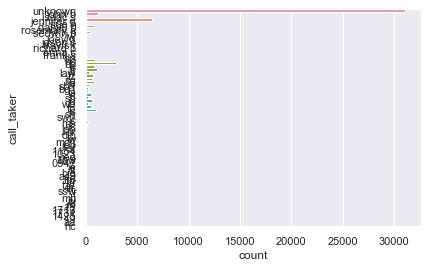

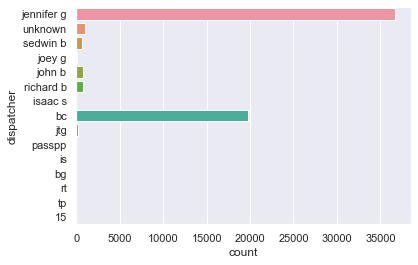

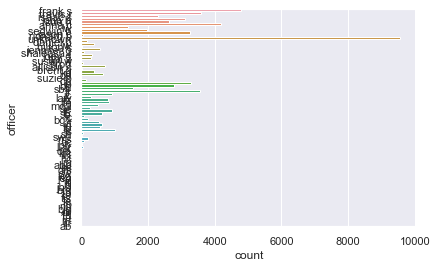

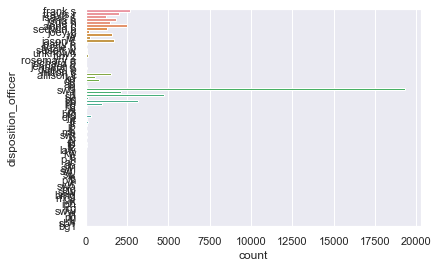

In [88]:
plot_counts(name_cols)

In [89]:
#df.drop(columns = name_cols, inplace=True)

## dropping columns

In [90]:
# # profile report
# pandas_profiling.ProfileReport(df)

# observations from pandas profile report:

# - lots of columns missing data

# unneeded columns:
# - ARRIVAL TIME- has most at 00:00
# - AVAILABLE TIME- most at 00:00
# - CALL TAKER
# - COLLAR
# - COLLAR COLOR
# - IMPOUND NUMBER
# - INCIDENT TIME
# - PET NAME
# - REMARKS(too little data provided(3%), existing data doesn't appear to be useful)
# - VACCINATION DATE(99.5% missing)
# - VACCINATION NUMBER
# - ZIP CODE


# columns needing work or consider exclusion:
# - AGE 55% missing
# - X in front of BREED- cross breed?
# - CONDITION 31% missing
# - DISPATCHED OTHER and DISPATCHED SITUATION- what does it mean?
# - EQUIPMENT NUMBER - what does it mean?
# - FILE NUMBER - probably not useful
# - REQUEST TYPE and SERVICE CODE appear to provide same content
# - SEX contains only 37% M or F, other data missing or irregular
# - SIZE 30% missing
# - SPECIES 28% missing
# - TEMPERMENT 30% missing
# - COLOR 29% missing
# - LOCATION and COMPLAINT STREET can be merged somehow?


In [91]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number               0.0
incident_date             0.0
incident_time             0.0
dispatched_time          14.0
call_taker               27.0
dispatcher               17.0
dispatched_other          0.0
dispatched_situation     14.0
arrival_time             15.0
available_time           14.0
complainant_street        0.0
officer                  17.0
equipment_number          0.0
remarks                  97.0
impound_number            0.0
impound_date             28.0
impound_time             29.0
location                 28.0
municipality             28.0
zip_code                  0.0
species                   0.0
breed                     0.0
sex                      45.0
size                      0.0
color                     0.0
age                      55.0
condition                 0.0
temperment                0.0
collar                   66.0
collar_color             66.0
vaccination_number       99.0
vaccination_date        100.0
pet_name                 99.0
dispositio

With there being such little information on vaccination, those columns won't be looked at further. I decided to also not explore the remarks, collar features, and pet names as those features were all missing substantial amounts of data and I don't see them offering much value. 

In [92]:
pre_drop_df = df.copy()

In [93]:
df.drop(columns=['vaccination_date', 'vaccination_number', 'remarks', 'collar', 'collar_color', 'pet_name'], inplace=True)

In [94]:
# # removing columns with more than 1/3 missing data
# df.dropna(axis=1, thresh=(len(df)//1.5), inplace=True)

#df = df.dropna(axis=0)

In [95]:
df.shape

(72450, 36)

# __Explore__

### datetime features

#### times

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the officer was finished with the incident and once again available

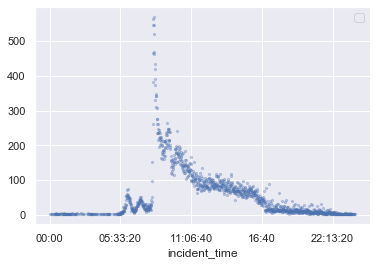

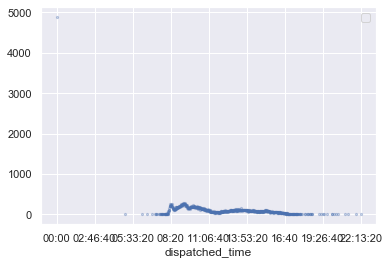

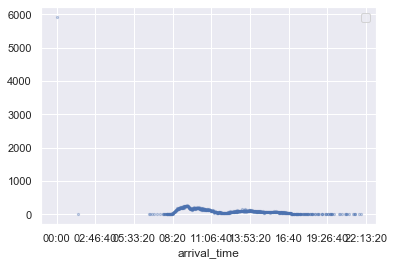

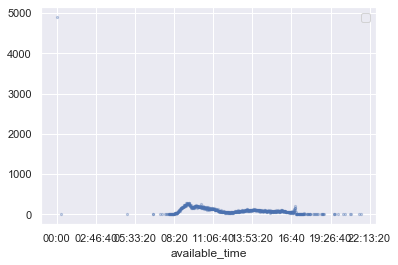

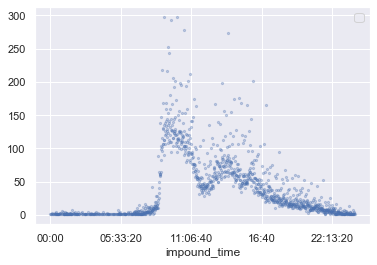

In [96]:
# DELETE CELL -- assigning time columns- done previously already
#time_cols= [col for col in df.columns if 'time' in col]
#time_cols



t_df = df[['incident_time'
                    ,'dispatched_time'
                     ,'arrival_time'
                     , 'available_time'
                     ,'impound_time']]

# t_df.columns

# comparing incident features by count/time
for col in time_cols:
    plot_dtcount(t_df, col, overlap = False, labels = time_cols)

For the most part, the times look consistent, but at 00:00, there are a couple of outliers. If using those time features, the 00:00 times will be excluded.

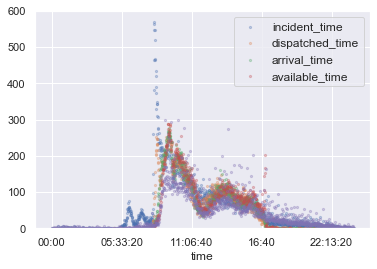

In [97]:
# plotting frequency of each time feature:

for col in time_cols:
    plot_dtcount(df, col
                 , (0, 600)
                 , labels = time_cols)

Around 9am-ish it reaches a peak, then once again rises between 12pm-4pm

In [98]:
# # DELETE THIS CELL--comparing distribution of time features(**NEEDS WORK**)

# comp_counts(time_cols, time_cols)

# f, axes = plt.subplots(1, 5,figsize=(30,5))
# plt.xlim(-5,50)

# for col, ax in zip(time_cols,(range(0,5))):
#     sns.distplot((df[col].dropna().value_counts()), ax=axes[ax])

#### dates

In [99]:
date_cols= [col for col in df.columns if 'date' in col]
date_cols

['incident_date', 'impound_date', 'disposition_date']

In [100]:
sns.set(style="darkgrid")

[]

[]

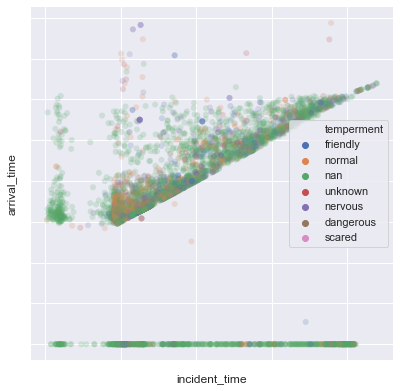

In [101]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x='incident_time', y= 'arrival_time'
    #x="incident_date", y="incident_time",
                ,hue="temperment"
                #, size="depth",
                #,palette="ch:r=-.2,d=.3_r"
                #hue_order=clarity_ranking,
                ,sizes=(1, 3), linewidth=0,
                data=df.head(5000), ax=ax, alpha=.2)
ax.set_xticklabels('')
ax.set_yticklabels('')

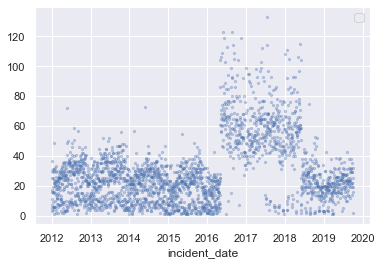

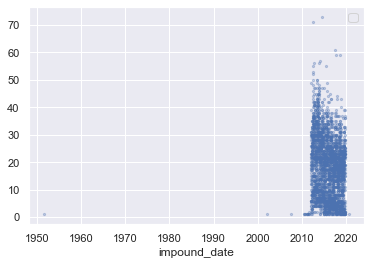

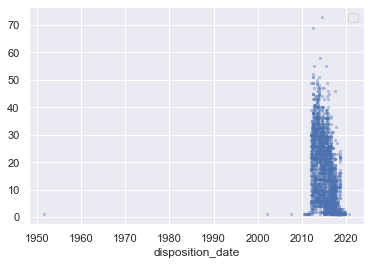

In [102]:
for col in date_cols:
    plot_dtcount(df, col, overlap = False, labels = date_cols)

In [103]:
df = df.sort_values(by='inc_dt')

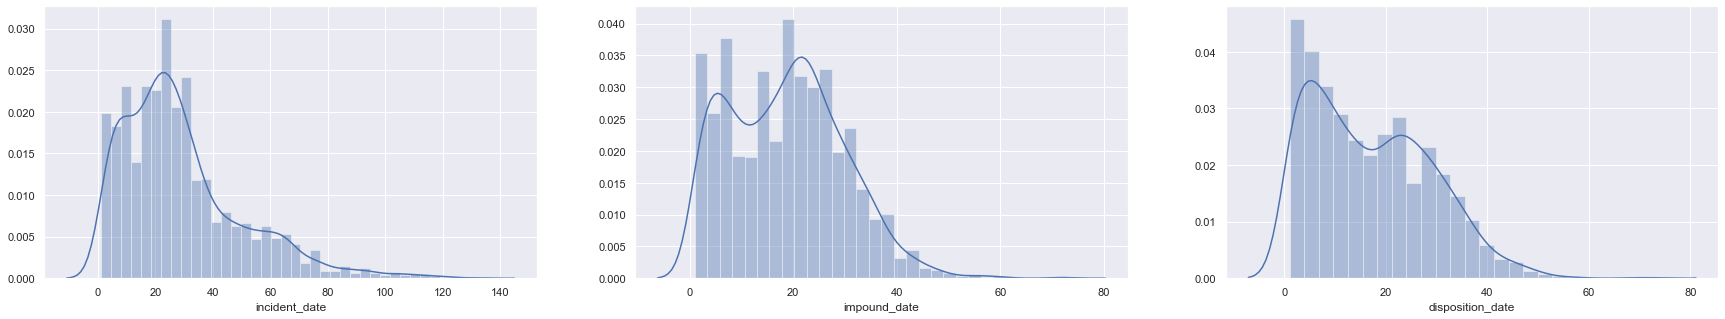

In [104]:
f, axes = plt.subplots(1, 3,figsize=(30,5))
for col, ax in zip(date_cols,(range(0,3))):
    
    sns.distplot((df[col].dropna()).value_counts(), ax=axes[ax]);

In [105]:
# #comparing distribution of date features
# #comp_counts(date_cols, date_cols)

# sns.set(font_scale=1)

# f, axes = plt.subplots(1, 2,figsize=(15,3))
# sns.distplot(df['incident_date'].value_counts(), ax=axes[0], color='black', bins=40)
# sns.distplot(df['impound_date'].value_counts(), ax=axes[1], color='black', bins=40);
# #sns.distplot(df['disposition_date'].value_counts(), ax=axes[2], color='black', bins=40);

#### condition, disposition, size, species, temperment

In [106]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

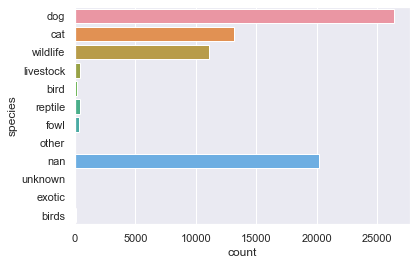

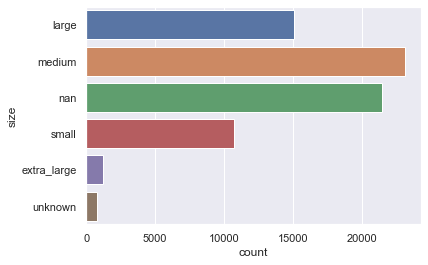

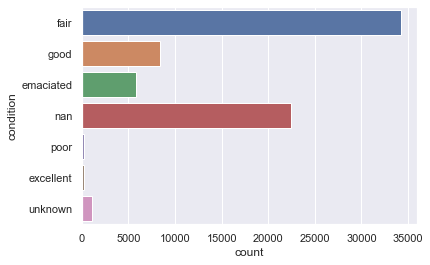

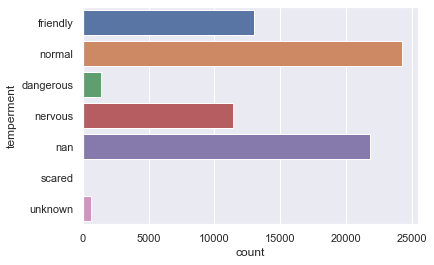

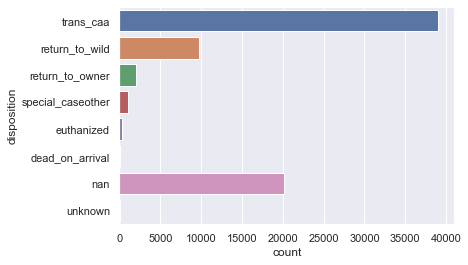

In [107]:
plot_counts(ssct_df)

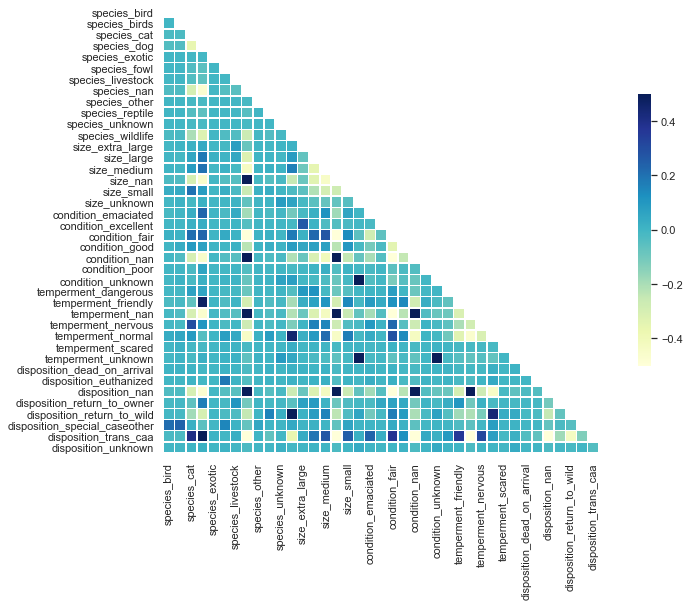

In [108]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, minv=-.5, maxv=.5)

#

In [109]:
# how much data would be sacrificed if dropping 'unknown'
len(df[~df.eq('unknown').any(1)])/ len(df)

0.49529330572808833

In [110]:
#how much data would remain of df if drop na and 'unknowns'
len(df.dropna()[~df.eq('unknown').any(1)])/len(df)

0.0125879917184265

In [111]:
# drop rows with any unknowns
df = df[~df.eq('unknown').any(1)]

# __IGNORE__

In [112]:
stop

NameError: name 'stop' is not defined

#### snippets I might come back to if 

In [ ]:
# #replacing alternate spellings of same breed- replaced with other methods
#df['breed'] = df['breed'].apply(lambda x: x.replace('bulldog_(english)', 'bulldog_english'))
#df['breed'] = df['breed'].apply(lambda x: x.replace('chow_chow', 'chow'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('boston_terrier', 'boston'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('poodle_-standard', 'poodle'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('basset_hound', 'basset'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('rottweiller', 'rott'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('rottweiler', 'rott'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('pit_bull', 'pitbull'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('pitbull', 'pit'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('_german_shepherd', 'german_shepherd'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('_retriever', 'retriever'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('labrador_retriever', 'labrador'))
# df = df.apply(lambda x: x.replace('poodle_(min/toy)', 'poodle_min/toy'))
# df = df.apply(lambda x: x.replace('poodle_standard', 'poodle'))
# df = df.apply(lambda x: x.replace('catahoula_hound', 'catahoula'))
# df = df.apply(lambda x: x.replace('english_bulldog', 'bulldog_english'))
# df = df.apply(lambda x: x.replace('bulldog_(french)', 'bulldog_french'))
# df = df.apply(lambda x: x.replace('boer', 'boxer'))
# df = df.apply(lambda x: x.replace('fo_terrier', 'fox_terrier'))
# df = df.apply(lambda x: x.replace('shar_pei', 'sharpei'))
# df = df.apply(lambda x: x.replace('alaskan__malamute','alaskan_malamute'))
# df = df.apply(lambda x: x.replace('brittany_spaniel', 'brittany'))
# df = df.apply(lambda x: x.replace('fohound', 'foxhound'))
# df = df.apply(lambda x: x.replace('other', 'unknown'))
# #df = df.apply(lambda x: x.replace('nan', np.NaN))

In [ ]:
# lower casing and eliminating characters, moved to later in cleaning
# for now, saved for later, but could also do this to only select columns to prevent issues

# df = df.apply(lambda x: x.astype(str).str.lower())
# df = df.apply(lambda x: x.astype(str).str.strip())
# df = df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [ ]:
# for col in cdsst:
#     df[col] = df[col].apply(lambda x: x.replace(' ', '_'))

# for col in cdsst:
#     clean_str(col)

# #
# for col in cdsst:
#     df[col] = df[col].astype(str)
#     df[col] = df[col].str.strip()
#     df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
#     df[col] = df[col].str.lower()
#     remove_numpunc(col, pattern='[^A-Za-z_]+')

In [ ]:
# replaced with regex
#characters = ('*',"'",'/','=',',','�','_',"'", '-', '(', ')', '.', '\\', ',,', ',,,', '_/_', ' ', '  ', '//','&')

#edit_replace(characters, ',')
#df['color'] = df['color'].str.strip()

In [ ]:
# pattern = '[^A-Za-z^/]+'
# list = [re.sub(pattern, '', i) for i in df.color] 
# list

In [ ]:
# # # how much data would remain after removing columns with more than 1/3 missing data
# df_drop_cols = (df.dropna(axis=1, thresh=(len(df))//1.5))
# len(df_drop_cols.columns)/ len(df.columns)
# #(len(df.dropna(axis=1, thresh=(len(df))//1.5)).columns)/len(df.columns)

# # # how much would then be left after then removing rows with more than 20 missing data
# len(df_drop_cols.dropna(axis=0, thresh=(20)))/len(df)

In [ ]:
# # looking at strings separated to evaluate how to edit; priority in high value counts
# results = Counter()
# df['color'].str.split(',').apply(results.update)
# pp.pprint (results)

In [ ]:
## replacing/seperating color strings
# # tan and white
# edit_replace(('tanwht'), 'tan,wht')

# # black and white
# edit_replace(('blkwht','blkwt'), 'blk,wht')

# # grey and white
# edit_replace(('graywhite','grywht','whtgry','greywht'), 'gry,wht')

# # black and brown
# edit_replace(('brnblk'), 'br,bl')

# # brown and white
# edit_replace(('brwnwht','whtbrwn'), 'brn,wht')

# # grey and black
# edit_replace(('gryblk'), 'gry,blk')

# # green and yellow
# edit_replace(('greenyellow'), 'grn,yel')

# # grey and yellow
# edit_replace(('gryyellow'), 'grey,yell')

# edit_replace(('brwnbkwh'), 'brn,blk,wht')

In [ ]:
#limiting colors to selected and also only with certain value count(no longer using this method)

#colors = ('wht', 'bk', 'gry', 'br', 'tn', 'spot', 'or', 'tab', 'blue', 'red', 'ylw', 'calico', 'tri', 'green', 'multi', 'dark', 'light', 'pink')

#ndf = df[~df['color'].isin([colors])]

#ndf = ndf[ndf.color.value_counts()>=20]

#ndf.color.value_counts()

In [ ]:
# def clean_str(col, df=df):
# #    for col in cols:
#     df[col] = df[col].astype(str)
#     df[col] = df[col].str.strip()
#     df[col] = df[col].str.lower()
# #     if pattern= pattern= '[^A-Za-z_]+':
# #         df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
#     # regex for letters and '_' only, unless pattern reassigned:
# #     if regex:
# #         pattern = pattern
# #         df[col] = [re.sub(pattern, '', i) for i in df[col]] 
# #     return df[col]

# # #         #print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

In [ ]:
# # maybe creating list of dog breeds, if wanting to analyze seperately from other animals
# dogs = ('pit', 'labrador', 'terrier', 'german_shepherd', 'shepherd', 'chihuahua', 'hound', 'rott'
#         , 'boxer', 'beagle', 'catahoula', 'chow', 'shih_tzu', 'dachshund', 'retriever', 'husky'
#         , 'yorkshire_terrier', 'american_bulldog', 'poodle', 'australian_shepherd', 'poodle_min/toy'
#         , 'collie', 'pomeranian', 'mastiff', 'golden_retriever', 'maltese', 'cocker_spaniel', 'healer'
#         , 'doberman_pinscher', 'miniature_pinscher', 'border_collie', 'schnauzer', 'great_dane'
#         , 'rat_terrier', 'akita', 'jack_russel_terrier', 'bulldog_english', 'spaniel', 'doberman'
#         , 'pug', 'pekingese', 'basset', 'dalmation', 'boston', 'weimeraner', 'lhasa_apso', 'pointer'
#         , 'rhodesian_ridgeback', 'sharpei', 'great_pyrenees', 'bull_terrier', 'bichons_frise', 'bloodhound'
#         , 'saint_bernard', 'springer_spaniel', 'sheepdog', 'alaskan_malamute', 'scottish_terrier'
#         , 'cairn_terrier', 'staffordshire_bull_terrier', 'setter', 'sheltie', 'cane_corso', 'whippet'
#         ,  'basenji', 'spitz', 'greyhound', 'walker_hound', 'siberian_husky', 'west_highland_terrier'
#         , 'american_eskimo', 'bull_mastiff', 'brittany', 'bluetick_hound', 'foxhound', 'australian_cattle'
#         , 'american_staffordshire_terrier', 'bulldog_french', 'australian_blue_heeler', 'bourvier_des_flanders'
#         , 'fox_terrier', 'wolf', 'coonhound', 'norweigian_elkhound')

In [ ]:
# # (to maximize notebook screen size):
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# #sns overlapping distplot
# def comp_counts(cols, labels):
#     sns.set(rc={'figure.figsize':(10, 5)})
#     plt.xlim(-5,100)
#     plt.title("times")
#     for col, label in zip(cols, labels):
#         sns.distplot(df[col].value_counts(), label=label, bins=40)
#     plt.legend()
#     plt.show();

In [ ]:
# [re.sub('[^A-Za-z/]+','', i) for i in df.breed]

# # # removing digits
# # def remove(list): 
# #     pattern = '[0-9]'
# #     list = [re.sub(pattern, '', i) for i in list] 
# #     return list
# # df['color'] = (remove(df.color))

# # replacing extra punctuations with '/'  (** look into more efficient regex methods**)
# characters = ('�','_',"'", '-', '(', ')', '.', '\\', ',,', ',,,', '_/_', ' ', '  ', '//')

# edit_replace(characters, '/')

####  IGNORE:  *Pet names (just for fun)

Dropping columns with few non-nulls, but curious about Baton Rouge's most common pet names, keeping in mind only 1% of incident reports included a name.

In [ ]:
df.pet_name.value_counts().head(15)

'Max' and 'Coco' are tied at 17, but most lie within the single digits. One would assume most of these correspond to 'dog' or 'cat' species, do they satisfy that assumption?

In [ ]:
# percent of names provided in relation to species
p_names_only = df[['pet_name','species']]
p_names_only = p_names_only.dropna()
p_name_ratio = p_names_only['species'].value_counts()/df['species'].value_counts()
p_name_ratio.plot.bar();

Of the dataset as a whole, these are the percentages of species with names included in reports. It looks like livestock incident reports included names more often than cats. Not surprisingly, dogs overwhelmingly had their names included in the incident reports. 

However, due to the amount of missing data, no justifiable conclusions can be made from this alone. 

___
another 'just for fun' thing:
looking at the disposition of animals with names on report:

In [ ]:
# percent of names provided in relation to species
d_names_only = df[['pet_name','temperment']]
d_names_only = d_names_only.dropna()
d_name_ratio = d_names_only['temperment'].value_counts()/df['temperment'].value_counts()
d_name_ratio.plot.bar();

# experimental joining dataset

## crime and unemployment

In [ ]:
# crime_df = pd.read_csv('Baton_Rouge_Crime_Incidents.csv')

In [ ]:
# unemp_df = pd.read_csv('BATO922URN.csv')

In [ ]:
# crime_df.head()

In [ ]:
# crime_df.info()

In [ ]:
# crime_df = pd.read_csv('Baton_Rouge_Crime_Incidents.csv')

In [ ]:
# unemp_df = pd.read_csv('BATO922URN.csv')

In [ ]:
# crime_df.offense_time

In [ ]:
# removing spaces and lower casing the column names
crime_df.columns = crime_df.columns.str.lower()
crime_df.columns = crime_df.columns.str.strip()
crime_df.columns = crime_df.columns.str.replace(' ', '_')

In [ ]:
# time columns to list
time_cols= [col for col in crime_df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    crime_df[col] = pd.to_datetime(crime_df[col], errors='ignore', format="%H:%M")
    #.dt.time

In [ ]:
# impound date + impound time = impound datetime
crime_df['datetime'] = pd.to_datetime(crime_df['offense_date'].apply(str)+' '+crime_df['offense_time'], errors ='ignore')